<a href="https://colab.research.google.com/github/BL-Labs/Jupyter-notebooks-projects-using-BL-Sources/blob/master/LOD_SPARQL/00_bnb_lod_resrouces_by_subject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BNB -- SPARQL query - resources by subject

The [BNB Linked Data Platform](https://bnb.data.bl.uk/) provides access to the [British National Bibliography (BNB)](http://www.bl.uk/bibliographic/natbib.html) published as linked open data and made available through SPARQL services. 

This notebook explains how to query it to retrieve records of resources indexed under a given Subject / Topic (LCSH).

*Inspired by:*

https://github.com/hibernator11/notebook-lod-libraries 
by Gustavo Candela (https://github.com/hibernator11), Research and Development department at The Biblioteca Virtual Miguel de Cervantes, University of Alicante, Spain

## Global configuration

Set the Subject to search:

In [0]:
Subject = 'Nanotubes'

#### Required modules / libraries

In [0]:
import requests
import pandas as pd
import json
import csv
from pandas.io.json import json_normalize

## Let's query the repository by asking the publications indexed by the defined Subject
We will use the [SPARQL endpoint](https://bnb.data.bl.uk/flint-sparql) to create the query and configure the request to retrieve json as a result.

In [52]:
url = 'https://bnb.data.bl.uk/sparql'
query = """
PREFIX bibo: <http://purl.org/ontology/bibo/> 
PREFIX dct: <http://purl.org/dc/terms/> 
PREFIX schema: <http://schema.org/> 

SELECT ?resource ?isbn ?title ?date ?author WHERE { 
      ?resource dct:subject <http://bnb.data.bl.uk/id/concept/lcsh/{0}>; 
      bibo:isbn13 ?isbn ; 
      dct:title ?title ; 
      schema:author ?author ; 
      schema:datePublished ?date . 
}
"""

query = query.format(Subject)

# use json as a result
headers = {'Accept': 'application/sparql-results+json'}
r = requests.get(url, params = {'format': 'application/sparql-results+json', 'query': query}, headers=headers)
print('Elements retrieved!')


Elements retrieved!


In [0]:
# print(r.text)

## Save as a CSV 

In [54]:
bnbdata = json.loads(r.text)

# we need to delete bnb_records.csv case it exists from previous runs 
# if it doesn't exist yet, it will give an error "rm: cannot remove 'bnb_records.csv': No such file or directory", that's just fine! :)
!rm ret_records.csv

with open('ret_records.csv', 'w', newline='') as file:
    csv_out = csv.writer(file, delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)    

    #csv_out = csv.writer(open('bnb_records.csv', 'w'), delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)
    csv_out.writerow(['resource', 'isbn', 'title', 'date', 'author'])

    for i in bnbdata['results']['bindings']:
        resource = isbn = title = date =''

        resource = i['resource']['value']
        #if "place" in i:
        isbn = i['isbn']['value']
        title = i['title']['value']
        date = i['date']['value']
        author = i['author']['value']

        csv_out.writerow([resource,isbn,title,date,author])

print('Open the generated CSV to see all its contents -- Google Colab: under "Files" > click "ret_records.csv" -- we will also explore it bellow.')

Open the generated CSV to see all its contents -- Google Colab: under "Files" > click "ret_records.csv" -- we will also explore it bellow.


## Exploring the data

In [0]:
# Load the CSV file from GitHub.
# This puts the data in a Pandas DataFrame
df = pd.read_csv('ret_records.csv')

In [57]:
df.head(5)

,resource,isbn,title,date,author
0,http://bnb.data.bl.uk/id/resource/014938681,9783527407187,Carbon nanotubes : an introduction to the basi...,2009-05,http://bnb.data.bl.uk/id/person/ReichS%28Steph...
1,http://bnb.data.bl.uk/id/resource/018171695,9781498702102,"Carbon nanomaterials : synthesis, structure, p...",2017-01,http://bnb.data.bl.uk/id/person/MathurRakeshBe...
2,http://bnb.data.bl.uk/id/resource/019506374,9780429486050,Quantum chemistry of nanotubes : electronic cy...,2019,http://bnb.data.bl.uk/id/person/D%CA%B9i%EF%B8...
3,http://bnb.data.bl.uk/id/resource/019506374,9780429941801,Quantum chemistry of nanotubes : electronic cy...,2019,http://bnb.data.bl.uk/id/person/D%CA%B9i%EF%B8...
4,http://bnb.data.bl.uk/id/resource/019506374,9780429941818,Quantum chemistry of nanotubes : electronic cy...,2019,http://bnb.data.bl.uk/id/person/D%CA%B9i%EF%B8...


## How many items?

In [58]:
# How many items?
len(df)

54

### Let's count the number of resources per author

In [61]:
resources_by_author = df.groupby("author")["resource"].count()
resources_by_author

author
http://bnb.data.bl.uk/id/person/AgarwalArvind                                               2
http://bnb.data.bl.uk/id/person/AkasakaTakeshi                                              1
http://bnb.data.bl.uk/id/person/Al-HilliSafaa                                               1
http://bnb.data.bl.uk/id/person/BavykinDmitryV                                              2
http://bnb.data.bl.uk/id/person/BursetAtienzaPablo                                          2
http://bnb.data.bl.uk/id/person/ChenChangxin                                                2
http://bnb.data.bl.uk/id/person/ChiparaMircea                                               1
http://bnb.data.bl.uk/id/person/D%CA%B9i%EF%B8%A0a%EF%B8%A1chkovPN%28PavelNikolaevich%29    4
http://bnb.data.bl.uk/id/person/GradyBrianP                                                 1
http://bnb.data.bl.uk/id/person/GrimesCraigA                                                2
http://bnb.data.bl.uk/id/person/GrossiordNadia       

### Create a chart to visualize the results
This chart shows the number of resources by date of publication.

In [64]:
resources_by_date = df['date'].value_counts()
resources_by_date

2009       11
2011        7
2013        7
2017        6
2019        5
2012        3
2015        3
2005        2
2008        2
2010        2
2017-01     1
2016-08     1
2009-05     1
2019-02     1
2018        1
2016        1
Name: date, dtype: int64

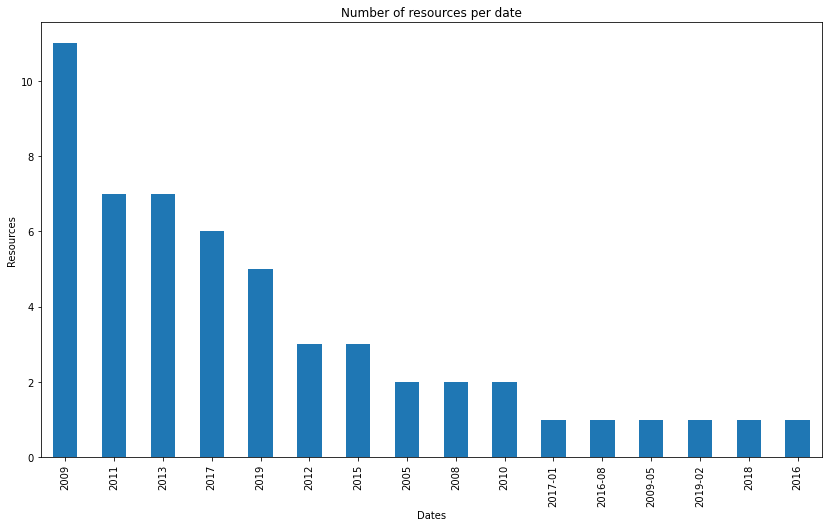

In [65]:
ax = resources_by_date.plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of resources per date")
ax.set_xlabel("Dates")
ax.set_ylabel("Resources")
plt.show()

### Let's group the items by year

In [0]:
# First we create a new column in pandas with the year
df['year'] = pd.DatetimeIndex(df['date']).year

In [68]:
df['year'].head(5)

0    2009
1    2017
2    2019
3    2019
4    2019
Name: year, dtype: int64

### Creating the chart by year

In [71]:
resources_by_year = df['year'].value_counts()
resources_by_year

2009    12
2017     7
2013     7
2011     7
2019     6
2015     3
2012     3
2016     2
2010     2
2008     2
2005     2
2018     1
Name: year, dtype: int64

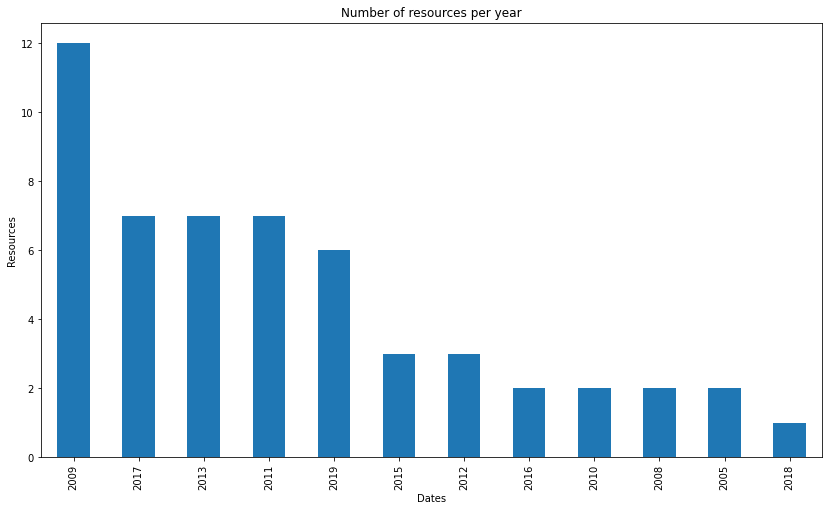

In [72]:
ax = resources_by_year.plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of resources per year")
ax.set_xlabel("Dates")
ax.set_ylabel("Resources")
plt.show()